# Analisi del grafico a pettine

## Boring Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Cambiare directory per spostarsi nella cartella principale
import os
while not os.getcwd().endswith('Laboratorio_SiPM'):
    os.chdir('..')

import sys
sys.path.append('Config')
from lablib import *

In [ ]:
def crop_df(df: pd.DataFrame, N: int, thr = 0) -> pd.DataFrame:
    """
    Remove groups of consecutive numbers under the threshold from the DataFrame.
    """
    is_zero = df.iloc[:,1] <= thr
    group_id = (is_zero != is_zero.shift()).cumsum()
    removal_mask = pd.Series(False, index=df.index)
    for grp, group_indices in df.groupby(group_id).groups.items():
        if is_zero.loc[group_indices[0]] and len(group_indices) > N:
            removal_mask.loc[group_indices] = True
    return df[~removal_mask].copy()

def assign_errors(df: pd.DataFrame, lim = 30) -> np.ndarray:
    """
    Assegna un errore a ciascun valore in base al valore stesso.
    L'errore è considerato gaussiano se ci sono abbastanza eventi.
    Se il numero di eventi è minore di lim, va riconsiderato.
    """
    ys = list(df.iloc[:,1])
    tot = np.sum(ys)
    ers = np.zeros(len(df))

    i = 0
    for y in ys:
        if y > lim: # type: ignore
            ers[i] = np.sqrt(y) # type: ignore
        else:
            ers[i] = np.sqrt(lim) # FIXME
            #ers[i] = np.sqrt(y * y/tot * (1 - y/tot))
        i += 1

    return ers

def six_gauss_plus_backgrd(x, mu1, mu2, mu3, mu4, mu5, mu6, 
                           sig1, sig2, sig3, sig4, sig5, sig6,
                           scale1, scale2, scale3, scale4, scale5, scale6, 
                           bkg_mu, bkg_sigma, bkg_scale):
    
    return (scale1*stats.norm.pdf(x, mu1, sig1) +
            scale2*stats.norm.pdf(x, mu2, sig2) +
            scale3*stats.norm.pdf(x, mu3, sig3) +
            scale4*stats.norm.pdf(x, mu4, sig4) +
            scale5*stats.norm.pdf(x, mu5, sig5) +
            scale6*stats.norm.pdf(x, mu6, sig6)) + \
            (bkg_scale * stats.norm.pdf(x, bkg_mu, bkg_sigma))

def eight_gauss_plus_backgrd(x, mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8,
                            sig1, sig2, sig3, sig4, sig5, sig6, sig7, sig8,
                            scale1, scale2, scale3, scale4, scale5, scale6, scale7, scale8,
                            bkg_mu, bkg_sigma, bkg_scale):
    
    return (scale1*stats.norm.pdf(x, mu1, sig1) +
                scale2*stats.norm.pdf(x, mu2, sig2) +
                scale3*stats.norm.pdf(x, mu3, sig3) +
                scale4*stats.norm.pdf(x, mu4, sig4) +
                scale5*stats.norm.pdf(x, mu5, sig5) +
                scale6*stats.norm.pdf(x, mu6, sig6) +
                scale7*stats.norm.pdf(x, mu7, sig7) +
                scale8*stats.norm.pdf(x, mu8, sig8)) + \
                (bkg_scale * stats.norm.pdf(x, bkg_mu, bkg_sigma))

def calculate_distances(vals: list, ers: list) -> tuple[list, list]:
    distances = []
    errors = []
    for i in range(len(vals)-1):
        distances.append(vals[i+1] - vals[i])

        # per calcolare l'errore della distanza, sommiamo gli errori in quadratura
        # che in questo caso corrisponde alla formula generale di propagazione degli errori
        errors.append(np.sqrt(ers[i]**2 + ers[i+1]**2))

    return distances, errors

In [10]:
pettine53 = pd.read_csv('Dati/Configurazione/Gain_V/File csv (corretti)/pettine_dark_count_v53.csv')
pettine53_5 = pd.read_csv('Dati/Configurazione/Gain_V/File csv (corretti)/pettine_dark_count_v53_5.csv')
pettine54 = pd.read_csv('Dati/Configurazione/Gain_V/File csv (corretti)/pettine_dark_count_v54.csv')
pettine54_5 = pd.read_csv('Dati/Configurazione/Gain_V/File csv (corretti)/pettine_dark_count_v54_5.csv')
pettine55_5 = pd.read_csv('Dati/Configurazione/Gain_V/File csv (corretti)/pettine_dark_count_v55_5.csv')

thr_noise = 5
thr_sequence = 10
thr_errors = 30

p53 = crop_df(pettine53, thr_sequence, thr_noise) # valore di 5 arbitrario
p53_5 = crop_df(pettine53_5, thr_sequence, thr_noise)
p54 = crop_df(pettine54, thr_sequence, thr_noise)
p54_5 = crop_df(pettine54_5, thr_sequence, thr_noise)
p55_5 = crop_df(pettine55_5, thr_sequence, thr_noise)

p53_err = assign_errors(p53, thr_errors)
p53_5_err = assign_errors(p53_5, thr_errors)
p54_err = assign_errors(p54, thr_errors)
p54_5_err = assign_errors(p54_5, thr_errors)
p55_5_err = assign_errors(p55_5, thr_errors)

## Analisi

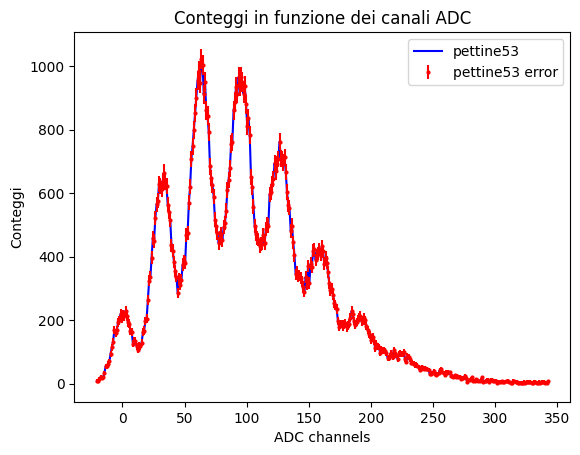

In [11]:
# commentare quelle che non servono

plt.plot(p53.iloc[:,0], p53.iloc[:,1], label='pettine53', color='blue')
plt.errorbar(p53.iloc[:,0], p53.iloc[:,1], yerr=p53_err, fmt='o', color='red', markersize=2, label='pettine53 error')

#plt.plot(p53_5.iloc[:,0], p53_5.iloc[:,1], label='pettine53_5', color='cyan')
#plt.plot(p54.iloc[:,0], p54.iloc[:,1], label='pettine54', color='red')
#plt.plot(p54_5.iloc[:,0], p54_5.iloc[:,1], label='pettine54_5', color='orange')
#plt.plot(p55_5.iloc[:,0], p55_5.iloc[:,1], label='pettine55_5', color='purple')

plt.xlabel('ADC channels')
plt.ylabel('Conteggi')
plt.title('Conteggi in funzione dei canali ADC')
plt.legend()
plt.show()

### Analisi pettine 53 V

In [12]:
par53, val53, err53, pval53, dof53, qsq53, *other = LS_fit(p53.iloc[:,0], p53.iloc[:,1], p53_err, six_gauss_plus_backgrd, 
                                       mu1=0, mu2=30, mu3=60, mu4=90, mu5=130, mu6=160,
                                       scale1=1e3, scale2=1e4, scale3=1e4, scale4=1e4, scale5=1e4, scale6=5e3,
                                       sig1=10, sig2=10, sig3=10, sig4=10, sig5=10, sig6=10,
                                       bkg_mu=100, bkg_sigma=100, bkg_scale=10000,
                                       disp=1)

if 1: # solo per non farlo uscire sempre
    for i in range(len(par53)):
        print(f"parametro {par53[i]}: {val53[i]:.5g} ± {err53[i]:.5g}")

    print("----------")

    print(f"chi2 ridotto: {qsq53/dof53:.5g}")
    print(f"p-value: {pval53:.5g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 390.3 (χ²/ndof = 1.1)      │             Nfcn = 1650              │
│ EDM = 3.85e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu1       │   0.40    │   0.18    │            │            │         │         │       │
│ 1 │ mu2       │   31.79   │   0.12    │            │            │         │         │       │
│ 2 │ mu3       │   62.96   │   0.10    │            │            │         │         │       │
│ 3 │ mu4       │   94.47   │   0.12    │            │            │         │         │       │
│ 4 │ mu5       │  126.25   │   0.16    │            │            │         │         │       │
│ 5 │ mu6       │  158.64   │   0.29    │            │            │         │         │       │
│ 6 │ sig1      │   7.22    │   0.23    │            │            │         │         │       │
│ 7 │ sig2      │   8.02    │   0.14    │            │            │         │         │       │
│ 8 │ sig3      │   8.30    │   0.15    │            │            │         │         │       │
│ 9 │ sig4      │   8.50    │   0.17    │            │            │         │         │       │
│ 10│ sig5      │   8.02    │   0.22    │            │            │         │         │       │
│ 11│ sig6      │   6.51    │   0.29    │            │            │         │         │       │
│ 12│ scale1    │  3.68e3   │  0.17e3   │            │            │         │         │       │
│ 13│ scale2    │  11.9e3   │   0.4e3   │            │            │         │         │       │
│ 14│ scale3    │  17.9e3   │   0.5e3   │            │            │         │         │       │
│ 15│ scale4    │  16.3e3   │   0.6e3   │            │            │         │         │       │
│ 16│ scale5    │   9.5e3   │   0.4e3   │            │            │         │         │       │
│ 17│ scale6    │  3.08e3   │  0.20e3   │            │            │         │         │       │
│ 18│ bkg_mu    │   135.3   │    3.2    │            │            │         │         │       │
│ 19│ bkg_sigma │   58.8    │    1.2    │            │            │         │         │       │
│ 20│ bkg_scale │  38.5e3   │   2.1e3   │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│           │       mu1       mu2       mu3       mu4       mu5       mu6      sig1      sig2      sig3      sig4      sig5      sig6    scale1    scale2    scale3    scale4    scale5    scale6    bkg_mu bkg_sigma bkg_scale │
├───────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       mu

parametro mu1: 0.39725 ± 0.17993
parametro mu2: 31.794 ± 0.11574
parametro mu3: 62.956 ± 0.10281
parametro mu4: 94.47 ± 0.11905
parametro mu5: 126.25 ± 0.16386
parametro mu6: 158.64 ± 0.29057
parametro sig1: 7.2223 ± 0.23056
parametro sig2: 8.0223 ± 0.14337
parametro sig3: 8.2955 ± 0.14586
parametro sig4: 8.5017 ± 0.17159
parametro sig5: 8.0169 ± 0.22227
parametro sig6: 6.5106 ± 0.29048
parametro scale1: 3677.9 ± 174.51
parametro scale2: 11858 ± 355.57
parametro scale3: 17905 ± 543.36
parametro scale4: 16319 ± 590.03
parametro scale5: 9485 ± 435.89
parametro scale6: 3075.5 ± 198.04
parametro bkg_mu: 135.33 ± 3.1998
parametro bkg_sigma: 58.829 ± 1.1932
parametro bkg_scale: 38511 ± 2125
----------
chi2 ridotto: 1.1379
p-value: 0.03973


In [ ]:
peaks53 = val53[:6]
sig53 = val53[6:12]

dist53, dist_err53 = calculate_distances(peaks53, sig53)

print("Distanze pettine53:")
for i in range(len(dist53)):
    print(f" distanza {i+1}: {dist53[i]:.5g} ± {dist_err53[i]:.5g}")
print("----------")

dist53_mean = np.mean(dist53)
dist53_std = np.std(dist53)

print(f"Distanza media pettine 53v: {dist53_mean:.5g} ± {dist53_std:.5g}")

Distanze pettine53:
 distanza 1: 30 ± 14.142
 distanza 2: 30 ± 14.142
 distanza 3: 30 ± 14.142
 distanza 4: 40 ± 14.142
 distanza 5: 30 ± 14.142
----------
Distanza media pettine 53v: 32 ± 4


**Commento** \
vedendo i risultati, direi di considerare la distanza media e la deviazione standard


### Analisi Pettine 53.5 V

In [ ]:
par53_5, val53_5, err53_5, pval53_5, dof53_5, qsq53_5, *other = LS_fit(p53_5.iloc[:,0], p53_5.iloc[:,1], p53_5_err, eight_gauss_plus_backgrd,
                                                                        mu1=0, mu2=50, mu3=100, mu4=150, mu5=200, 
                                                                        mu6=250, mu7=330, mu8=380,
                                                                        scale1=1e3, scale2=1e4, scale3=1e4, scale4=1e4, 
                                                                        scale5=1e4, scale6=1e4, scale7=1e3, scale8=1e3,
                                                                        sig1=10, sig2=10, sig3=10, sig4=10, 
                                                                        sig5=10, sig6=10, sig7=10, sig8=10,
                                                                        bkg_mu=100, bkg_sigma=100, bkg_scale=10000,
                                                                        disp=1)

if 1:
    for i in range(len(par53_5)):
        print(f"parametro {par53_5[i]}: {val53_5[i]:.5g} ± {err53_5[i]:.5g}")

    print("----------")
    print(f"chi2 ridotto: {qsq53_5/dof53_5:.5g}")
    print(f"p-value: {pval53_5:.5g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = inf (χ²/ndof = inf)        │             Nfcn = 12564             │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu1       │     0     │    nan    │            │            │         │         │       │
│ 1 │ mu2       │    5e1    │    nan    │            │            │         │         │       │
│ 2 │ mu3       │    1e2    │    nan    │            │            │         │         │       │
│ 3 │ mu4       │   1.5e2   │    nan    │            │            │         │         │       │
│ 4 │ mu5       │    2e2    │    nan    │            │            │         │         │       │
│ 5 │ mu6       │   2.5e2   │    nan    │            │            │         │         │       │
│ 6 │ mu7       │   3.3e2   │    nan    │            │            │         │         │       │
│ 7 │ mu8       │   3.8e2   │    nan    │            │            │         │         │       │
│ 8 │ sig1      │    1e1    │    nan    │            │            │         │         │       │
│ 9 │ sig2      │    1e1    │    nan    │            │            │         │         │       │
│ 10│ sig3      │    1e1    │    nan    │            │            │         │         │       │
│ 11│ sig4      │    1e1    │    nan    │            │            │         │         │       │
│ 12│ sig5      │    1e1    │    nan    │            │            │         │         │       │
│ 13│ sig6      │    1e1    │    nan    │            │            │         │         │       │
│ 14│ sig7      │    1e1    │    nan    │            │            │         │         │       │
│ 15│ sig8      │    1e1    │    nan    │            │            │         │         │       │
│ 16│ scale1    │    1e3    │    nan    │            │            │         │         │       │
│ 17│ scale2    │    1e4    │    nan    │            │            │         │         │       │
│ 18│ scale3    │    1e4    │    nan    │            │            │         │         │       │
│ 19│ scale4    │    1e4    │    nan    │            │            │         │         │       │
│ 20│ scale5    │    1e4    │    nan    │            │            │         │         │       │
│ 21│ scale6    │    1e4    │    nan    │            │            │         │         │       │
│ 22│ scale7    │    1e3    │    nan    │            │            │         │         │       │
│ 23│ scale8    │    1e3    │    nan    │            │            │         │         │       │
│ 24│ bkg_mu    │    1e2    │    nan    │            │            │         │         │       │
│ 25│ bkg_sigma │    1e2    │    nan    │            │            │         │         │       │
│ 26│ bkg_scale │    1e4    │    nan    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────────────────────────────────────────────────────

parametro mu1: 0 ± nan
parametro mu2: 50 ± nan
parametro mu3: 100 ± nan
parametro mu4: 150 ± nan
parametro mu5: 200 ± nan
parametro mu6: 250 ± nan
parametro mu7: 330 ± nan
parametro mu8: 380 ± nan
parametro sig1: 10 ± nan
parametro sig2: 10 ± nan
parametro sig3: 10 ± nan
parametro sig4: 10 ± nan
parametro sig5: 10 ± nan
parametro sig6: 10 ± nan
parametro sig7: 10 ± nan
parametro sig8: 10 ± nan
parametro scale1: 1000 ± nan
parametro scale2: 10000 ± nan
parametro scale3: 10000 ± nan
parametro scale4: 10000 ± nan
parametro scale5: 10000 ± nan
parametro scale6: 10000 ± nan
parametro scale7: 1000 ± nan
parametro scale8: 1000 ± nan
parametro bkg_mu: 100 ± nan
parametro bkg_sigma: 100 ± nan
parametro bkg_scale: 10000 ± nan
----------
chi2 ridotto: inf
p-value: 0


In [ ]:
peaks53_5 = val53_5[:8]
sig53_5 = val53_5[8:16]

dist53_5, dist_err53_5 = calculate_distances(peaks53_5, sig53_5)
dist53_5_mean = np.mean(dist53_5)
dist53_5_std = np.std(dist53_5)

print(f"Distanza media pettine 53.5v: {dist53_5_mean:.5g} ± {dist53_5_std:.5g}")

Distanza media pettine 53.5v: 54.286 ± 10.498


### Analisi Pettine 54 V

da continuare \
\
non so se continuare ad aumentare il numero di gaussiane o fermarci \
a quante ne abbiamo gia' e prendere solo i picchi piu' alti